In [ ]:
import numpy as np
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display, clear_output

# Load your neural response data
dat = np.load('/home/maria/LuckyMouse2/pixel_transformer_neuro/data/processed/hybrid_neural_responses_reduced.npy')  # shape: (neurons, 118)
prob_matrix = dat / 50.0
epsilon = 1e-10
prob_matrix_safe = prob_matrix + epsilon
num_neurons, num_images = prob_matrix.shape

# Compute KL divergence from uniform
uniform_dist = np.full((num_images,), 1.0 / num_images)
kl_divs = []
for neuron_probs in prob_matrix_safe:
    neuron_dist = neuron_probs / np.sum(neuron_probs)
    kl = np.sum(uniform_dist * np.log(uniform_dist / neuron_dist))
    kl_divs.append(kl)
kl_divs = np.array(kl_divs)

# Bin setup
num_bins = 30
bin_edges = np.histogram_bin_edges(kl_divs, bins=num_bins)
bin_indices = np.digitize(kl_divs, bins=bin_edges) - 1

# Prepare data for each bin
bin_to_neuron_indices = {i: [] for i in range(num_bins)}
for idx, bin_idx in enumerate(bin_indices):
    if 0 <= bin_idx < num_bins:
        bin_to_neuron_indices[bin_idx].append(idx)

bin_counts = [len(bin_to_neuron_indices[i]) for i in range(num_bins)]
bin_labels = [f"{bin_edges[i]:.2f}–{bin_edges[i+1]:.2f}" for i in range(num_bins)]

# Widget for outputting the secondary plot
output_plot = widgets.Output()

# Define the click handler
def on_bar_click(trace, points, state):
    with output_plot:
        clear_output(wait=True)
        if points.point_inds:
            bin_idx = points.point_inds[0]
            neuron_ids = bin_to_neuron_indices.get(bin_idx, [])
            if neuron_ids:
                neuron_id = neuron_ids[0]
                sorted_events = np.sort(dat[neuron_id])[::-1]  # descending sort

                # Prepare x-axis as rank indices
                x_vals = np.arange(len(sorted_events))

                # Fit exponential: y = a * exp(-lambda * x)
                def exp_func(x, a, lambd):
                    return a * np.exp(-lambd * x)

                try:
                    popt, _ = curve_fit(exp_func, x_vals, sorted_events, p0=(sorted_events[0], 0.1))
                    y_fit = exp_func(x_vals, *popt)
                    fit_label = f"Exp Fit: a={popt[0]:.1f}, λ={popt[1]:.2f}"
                except RuntimeError:
                    y_fit = None
                    fit_label = "Fit failed"

                # Plot
                fig_detail = go.Figure()
                fig_detail.add_trace(go.Bar(
                    x=x_vals,
                    y=sorted_events,
                    name="Sorted Event Counts",
                    marker_color='royalblue'
                ))

                if y_fit is not None:
                    fig_detail.add_trace(go.Scatter(
                        x=x_vals,
                        y=y_fit,
                        name=fit_label,
                        mode='lines',
                        line=dict(color='red', dash='dash')
                    ))

                fig_detail.update_layout(
                    title=f"Sorted Event Counts + Exponential Fit\nFirst Neuron in Bin {bin_labels[bin_idx]}",
                    xaxis_title="Ranked Stimulus Index (Descending Response)",
                    yaxis_title="Event Count",
                    height=350
                )
                fig_detail.show()
            else:
                print("No neurons in this bin.")


# Create main histogram figure
fig = go.FigureWidget(
    data=[go.Bar(x=bin_labels, y=bin_counts, marker_color='lightskyblue')],
    layout=dict(
        title="KL Divergence from Uniform Distribution (per Neuron)",
        xaxis_title="KL Divergence Bin",
        yaxis_title="Number of Neurons",
        xaxis_tickangle=45,
        bargap=0.1
    )
)

# Attach the click callback
fig.data[0].on_click(on_bar_click)

# Display in notebook
display(fig)
display(output_plot)


FigureWidget({
    'data': [{'marker': {'color': 'lightskyblue'},
              'type': 'bar',
              'uid': '54dc391c-834c-4eb1-b739-97578a8e40a3',
              'x': [0.02–0.48, 0.48–0.95, 0.95–1.42, 1.42–1.89, 1.89–2.36,
                    2.36–2.83, 2.83–3.30, 3.30–3.77, 3.77–4.24, 4.24–4.70,
                    4.70–5.17, 5.17–5.64, 5.64–6.11, 6.11–6.58, 6.58–7.05,
                    7.05–7.52, 7.52–7.99, 7.99–8.46, 8.46–8.92, 8.92–9.39,
                    9.39–9.86, 9.86–10.33, 10.33–10.80, 10.80–11.27, 11.27–11.74,
                    11.74–12.21, 12.21–12.68, 12.68–13.14, 13.14–13.61,
                    13.61–14.08],
              'y': [2333, 1268, 1285, 1452, 1679, 1911, 2256, 2396, 2556, 2697,
                    2874, 2689, 2603, 2322, 2124, 1729, 1470, 1191, 894, 599, 354,
                    237, 123, 72, 46, 22, 12, 8, 5, 1]}],
    'layout': {'bargap': 0.1,
               'template': '...',
               'title': {'text': 'KL Divergence from Uniform Distributi

Output()

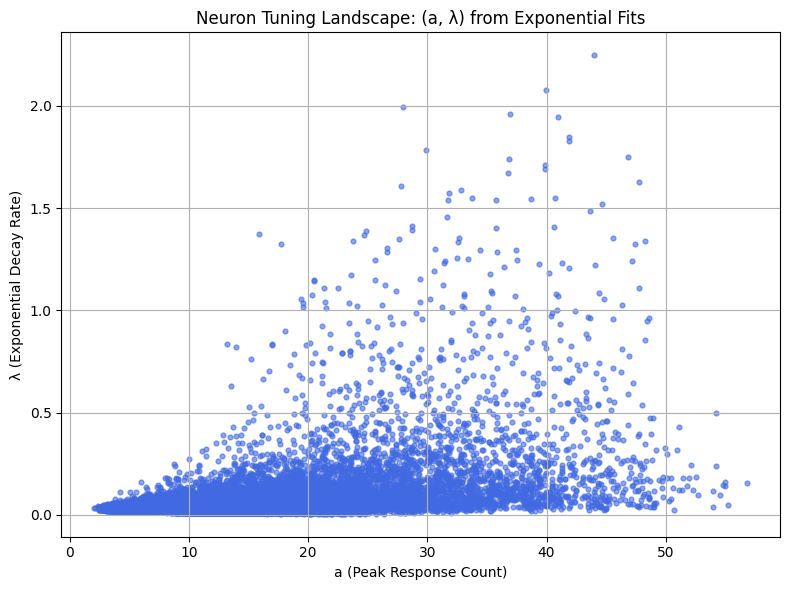

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Load your neural event count matrix ===
dat = np.load('/home/maria/LuckyMouse2/pixel_transformer_neuro/data/processed/hybrid_neural_responses_reduced.npy')
num_neurons, num_images = dat.shape

# === Define exponential model ===
def exp_func(x, a, lambd):
    return a * np.exp(-lambd * x)

# === Fit exponential to each neuron's sorted responses ===
a_vals = []
lambda_vals = []
fit_success = []

for i in range(num_neurons):
    sorted_counts = np.sort(dat[i])[::-1]
    x = np.arange(len(sorted_counts))
    try:
        popt, _ = curve_fit(exp_func, x, sorted_counts, p0=(sorted_counts[0], 0.1), maxfev=10000)
        a_vals.append(popt[0])
        lambda_vals.append(popt[1])
        fit_success.append(True)
    except RuntimeError:
        a_vals.append(np.nan)
        lambda_vals.append(np.nan)
        fit_success.append(False)

a_vals = np.array(a_vals)
lambda_vals = np.array(lambda_vals)
fit_success = np.array(fit_success)
valid = ~np.isnan(lambda_vals)

# === Scatter plot in (a, lambda) space ===
plt.figure(figsize=(8, 6))
plt.scatter(a_vals[valid], lambda_vals[valid], alpha=0.6, s=12, c='royalblue')
plt.xlabel("a (Peak Response Count)")
plt.ylabel("λ (Exponential Decay Rate)")
plt.title("Neuron Tuning Landscape: (a, λ) from Exponential Fits")
plt.grid(True)
plt.tight_layout()
plt.show()
